## AHC (1D)

In [145]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from matplotlib import pyplot as plt
from jenkspy import JenksNaturalBreaks

from src.clustering import SingleDimensionalClustererFinder, SklearnSingleDimensionalClustererFinder, GeneralClustererFinder
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_excel("../data/raw/ROS1_all data randomised.xlsx")
series = data["VALUE"].to_numpy()
data.head(3)

,WELL,row,column,VALUE,Well type,CONTROL OUTLIER,CTRL NEG Mean(VALUE),CTRL NEG Standard deviation(VALUE),CTRL NEG Median(VALUE),CTRL POS Mean(VALUE),...,CTRL POS Median(VALUE),CMPD Mean(VALUE),CMPD Standard deviation(VALUE),Z',Z' robust,% ACTIVATION,Z score,ACTIVITY (above 30%),ACTIVITY (Z score above 3),Transfer Status
0,A01,1,1,12123,CMPD,NaN,11282.0,388.181361,11274.5,96504.3125,...,96602.5,11926.059659,2610.13325,0.870037,0.870198,0.986831,0.075452,INACTIVE,Z score below 3,OK
1,A02,1,2,10507,CMPD,NaN,11282.0,388.181361,11274.5,96504.3125,...,96602.5,11926.059659,2610.13325,0.870037,0.870198,-0.909386,-0.543673,INACTIVE,Z score below 3,OK
2,A03,1,3,11176,CMPD,NaN,11282.0,388.181361,11274.5,96504.3125,...,96602.5,11926.059659,2610.13325,0.870037,0.870198,-0.124381,-0.287365,INACTIVE,Z score below 3,OK


### Silhouette metric

In [16]:
AHC_params = ParameterGrid({"n_clusters": range(2, 10), "linkage":['ward', 'average']})

AHC_clusterer_finder = SklearnSingleDimensionalClustererFinder(
    param_grid=AHC_params, 
    scoring_function=metrics.silhouette_score,
    clusterer=AgglomerativeClustering(n_clusters=2)# linkage = 'average')
)

best_AHC_prediction = AHC_clusterer_finder.cluster_data_series(series, verbose=True)

Params: {'linkage': 'ward', 'n_clusters': 2} | Score: 0.9038193627928365
Params: {'linkage': 'ward', 'n_clusters': 3} | Score: 0.8341166801103759
Params: {'linkage': 'ward', 'n_clusters': 4} | Score: 0.834935883652877
Params: {'linkage': 'ward', 'n_clusters': 5} | Score: 0.5648554008628156
Params: {'linkage': 'ward', 'n_clusters': 6} | Score: 0.5896534542683013
Params: {'linkage': 'ward', 'n_clusters': 7} | Score: 0.5898335030812537
Params: {'linkage': 'ward', 'n_clusters': 8} | Score: 0.6001165220702561
Params: {'linkage': 'ward', 'n_clusters': 9} | Score: 0.6007676673566165
Params: {'linkage': 'average', 'n_clusters': 2} | Score: 0.9038193627928365
Params: {'linkage': 'average', 'n_clusters': 3} | Score: 0.8837135222373859
Params: {'linkage': 'average', 'n_clusters': 4} | Score: 0.8409303252765453
Params: {'linkage': 'average', 'n_clusters': 5} | Score: 0.6817090576775502
Params: {'linkage': 'average', 'n_clusters': 6} | Score: 0.6819496195533233
Params: {'linkage': 'average', 'n_clu

### Davies-Boulding metric

In [31]:
# As previously, compared with Davies-Boulding metric
negated_davies_boulding = lambda *args, **kwargs: -metrics.davies_bouldin_score(*args, **kwargs)

AHC_clusterer_finder_DB = SklearnSingleDimensionalClustererFinder(
    param_grid=AHC_params, 
    scoring_function=negated_davies_boulding,
    clusterer=AgglomerativeClustering(n_clusters=2)
)

best_AHC_prediction_DB = AHC_clusterer_finder_DB.cluster_data_series(series, verbose=True)

Params: {'linkage': 'ward', 'n_clusters': 2} | Score: -0.3826233002663599
Params: {'linkage': 'ward', 'n_clusters': 3} | Score: -0.3278575275207647
Params: {'linkage': 'ward', 'n_clusters': 4} | Score: -0.29494341551968634
Params: {'linkage': 'ward', 'n_clusters': 5} | Score: -0.44996921495875536
Params: {'linkage': 'ward', 'n_clusters': 6} | Score: -0.44402075694950827
Params: {'linkage': 'ward', 'n_clusters': 7} | Score: -0.43099101144083135
Params: {'linkage': 'ward', 'n_clusters': 8} | Score: -0.4560019072252756
Params: {'linkage': 'ward', 'n_clusters': 9} | Score: -0.427750426031368
Params: {'linkage': 'average', 'n_clusters': 2} | Score: -0.3826233002663599
Params: {'linkage': 'average', 'n_clusters': 3} | Score: -0.34072005253407833
Params: {'linkage': 'average', 'n_clusters': 4} | Score: -0.3727299969149864
Params: {'linkage': 'average', 'n_clusters': 5} | Score: -0.4179327338985385
Params: {'linkage': 'average', 'n_clusters': 6} | Score: -0.38061336725698297
Params: {'linkage'

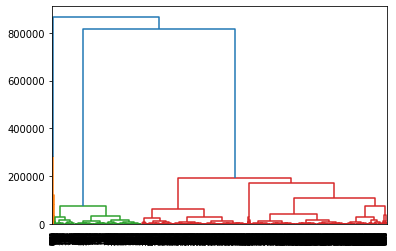

In [33]:
dendrogram = sch.dendrogram(sch.linkage(series.reshape(-1, 1), method='ward'))
plt.show()

## Combine experiment no. 1 and 2

In [34]:
def parse_barcode_col(data):
   data[['Barcode_prefix', 'Barcode_exp', 'Barcode_suffix']] = data['Barcode assay plate'].str.extract(pat='(.{13})([^0-9]*)(.*)') 
   return data

In [35]:
data_ROS1 = pd.read_excel("../data/raw/ROS1_DTT_fanonymised_limited.xlsx")
data_ROS1 = parse_barcode_col(data_ROS1)
# data_ROS1.head(3)

In [36]:
data_ROS2 = pd.read_excel("../data/raw/ROS2_HRP anonymised limited.xlsx")
data_ROS2 = parse_barcode_col(data_ROS2)
# data_ROS2.head(3)

In [169]:
# pd.set_option('display.max_columns', None)
data_all = pd.merge(data_ROS1, data_ROS2, left_on=['DTT  - compound ID', 'Barcode_prefix', 'Barcode_suffix'], right_on = ['HRP - compound ID', 'Barcode_prefix', 'Barcode_suffix'])\
    .rename(columns={'HRP - compound ID':'Compound ID'})[['Compound ID', 'Barcode_prefix', 'Barcode_suffix', 'VALUE_x', 'VALUE_y']]

data_all.head()

,Compound ID,Barcode_prefix,Barcode_suffix,VALUE_x,VALUE_y
0,102092,B1007L2002L03,1,27269,0.104
1,102092,B1007L2002L03,2,27290,0.105
2,102091,B1007L2002L03,1,27128,0.102
3,102091,B1007L2002L03,2,26992,0.111
4,102090,B1007L2002L03,1,27276,0.102


In [170]:
def standarize_column(df, col):
    new_col = col+'_stan'
    df[new_col] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [180]:
# min-max normalization
scaler = MinMaxScaler()
cols_to_norm = ['VALUE_x','VALUE_y']
new_names = ['VALUE_x_norm','VALUE_y_norm']
data_all[new_names] = scaler.fit_transform(data_all[cols_to_norm])
print(data_all.head())

X = data_all[new_names].to_numpy()
X

   Compound ID Barcode_prefix Barcode_suffix  VALUE_x  VALUE_y  VALUE_x_norm  \
0       102092  B1007L2002L03              1    27269    0.104      0.065126   
1       102092  B1007L2002L03              2    27290    0.105      0.065267   
2       102091  B1007L2002L03              1    27128    0.102      0.064183   
3       102091  B1007L2002L03              2    26992    0.111      0.063273   
4       102090  B1007L2002L03              1    27276    0.102      0.065173   

   VALUE_y_norm  
0      0.026987  
1      0.028486  
2      0.023988  
3      0.037481  
4      0.023988  


array([[0.06512636, 0.02698651],
       [0.06526683, 0.02848576],
       [0.06418318, 0.02398801],
       ...,
       [0.05953416, 0.02398801],
       [0.04867754, 0.02548726],
       [0.04719922, 0.02398801]])

In [177]:
AHC_params = ParameterGrid({"n_clusters": range(2, 10)})

AHC_clusterer_finder = GeneralClustererFinder(
    param_grid=AHC_params, 
    scoring_function=metrics.silhouette_score,
    clusterer=AgglomerativeClustering(n_clusters=2)
)

best_AHC_prediction = AHC_clusterer_finder.cluster_data_series(X, verbose=True)

Params: {'n_clusters': 2} | Score: 0.9668603343418097
Params: {'n_clusters': 3} | Score: 0.9521305831542471
Params: {'n_clusters': 4} | Score: 0.9402417116921766
Params: {'n_clusters': 5} | Score: 0.9399175691068355
Params: {'n_clusters': 6} | Score: 0.46455113565186196
Params: {'n_clusters': 7} | Score: 0.43657283028715305
Params: {'n_clusters': 8} | Score: 0.4367491504128263
Params: {'n_clusters': 9} | Score: 0.4371790043964146

DONE

Best Score: 0.9668603343418097
Best Params: {'n_clusters': 2}


In [178]:
AHC_clusterer_finder_DB = GeneralClustererFinder(
    param_grid=AHC_params, 
    scoring_function=negated_davies_boulding,
    clusterer=AgglomerativeClustering(n_clusters=2)
)

best_AHC_prediction_DB = AHC_clusterer_finder_DB.cluster_data_series(X, verbose=True)

Params: {'n_clusters': 2} | Score: -0.30042484963616106
Params: {'n_clusters': 3} | Score: -0.4604620712267778
Params: {'n_clusters': 4} | Score: -0.36315641499389817
Params: {'n_clusters': 5} | Score: -0.4137520945809069
Params: {'n_clusters': 6} | Score: -0.5759531919894366
Params: {'n_clusters': 7} | Score: -0.5443382822911221
Params: {'n_clusters': 8} | Score: -0.5250194985483421
Params: {'n_clusters': 9} | Score: -0.5065165464186339

DONE

Best Score: -0.30042484963616106
Best Params: {'n_clusters': 2}


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


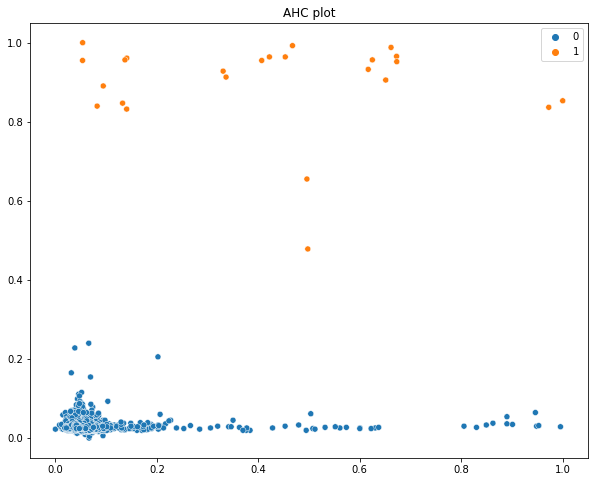

In [183]:
labels = AHC_clusterer_finder.cached_best_prediction
plt.figure(figsize=(10, 8))
sns.scatterplot(X[:,0], X[:,1], hue=labels).set_title('AHC plot')
plt.show() 